## Importation des librairies

In [2]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from pulp import *

## Formulation formelle du probl√®me
Le **probl√®me √† r√©soudre** est une version plus complexe du c√©l√®bre **probl√®me du voyageur de commerce (TSP)**.
###  Probl√®me du voyageur de commerce (TSP)

Dans le **TSP**, un vendeur doit visiter un certain nombre de villes **une seule fois chacune**, puis **revenir √† son point de d√©part**, en minimisant la **distance totale parcourue**.


###  Probl√®me de tourn√©es de v√©hicules (VRP)

Le **VRP** (*Vehicle Routing Problem*) est une **g√©n√©ralisation** du TSP.  
Cette fois, il ne s'agit pas d'un seul vendeur, mais de **plusieurs v√©hicules** qui doivent :

- partir d‚Äôun **d√©p√¥t central**,
- visiter un ensemble de **clients** pour effectuer des livraisons ou des ramassages,
- puis **revenir au d√©p√¥t**.

L‚Äôobjectif est d‚Äôorganiser les **tourn√©es de tous les v√©hicules** pour :

- **desservir tous les clients**,  
- **minimiser les co√ªts** (distance, temps, co√ªts...).

## Donn√©es du probl√®me
### Repr√©sentation du graphe

Le syst√®me est mod√©lis√© par un **graphe orient√© et pond√©r√©** : $ G = (V, E) $

avec :
- $ V = \{v_0, v_1, \dots, v_n\} $   Ensemble des **sommets**, repr√©sentant les villes ou les points √† visiter.

- $ E \subseteq V \times V $  Ensemble des **ar√™tes**, repr√©sentant les routes entre les villes.

- Chaque ar√™te $ (v_i, v_j) \in E $ est associ√©e √† trois **attributs** : la **distance** $ d_{ij} \in \mathbb{R}^{+} $, le **co√ªt mon√©taire** $ c_{ij} \in \mathbb{R}^{+} $ et le **temps de trajet** $ t_{ij} \in \mathbb{R}^{+} $.


- Un d√©p√¥t $ v_0 $ (point de d√©part et d‚Äôarriv√©e des tourn√©es)

- Un ensemble de $ k $ v√©hicules, chacun ayant une tourn√©e qui commence et se termine √† $ v_0 $



### Objectif

Trouver un ensemble de $ k $ tourn√©es (une par v√©hicule) telles que :

- Chaque client est visit√© une seule fois par un seul v√©hicule
- Le co√ªt total des tourn√©es est **minimis√©** (ex. : distance, temps et co√ªt total)
- Utilisation de moins de camion possible


### Contraintes

Nous avons choisi d‚Äôint√©grer deux contraintes suppl√©mentaires au probl√®me de base :

1. **Utilisation de plusieurs v√©hicules** : chaque v√©hicule part du d√©p√¥t, visite des clients, puis revient au d√©p√¥t.
2. **Co√ªt ou restriction de passage sur certaines ar√™tes** : certaines routes peuvent avoir un co√ªt plus √©lev√© (par exemple, travaux ou routes bloqu√©es)

## R√©duction polynomiale VRP vers TSP:
Le but de cette partie est de montrer que le VRP peut √™tre r√©duit en temps polynomiale.
- Le TSP consiste √† trouver une tourn√©e unique qui passe par tous les sommets une seule fois. 
- Le VRP consiste √† trouver k tourn√©es, chacune partant et revenant au d√©p√¥t $ v_0 $ , desservant tous les clients

## Repr√©sentation graphique du VRP

Nous avons commenc√© √† mod√©liser notre probl√®me VRP. Pour cela, on a utiliser un code python afin de pouvoir afficher nos graphes sans le respect des contraintes qui sera fait durant le projet

In [3]:
seed = random.randint(0, 100000)
print(f"Seed : {seed}")

Seed : 72664


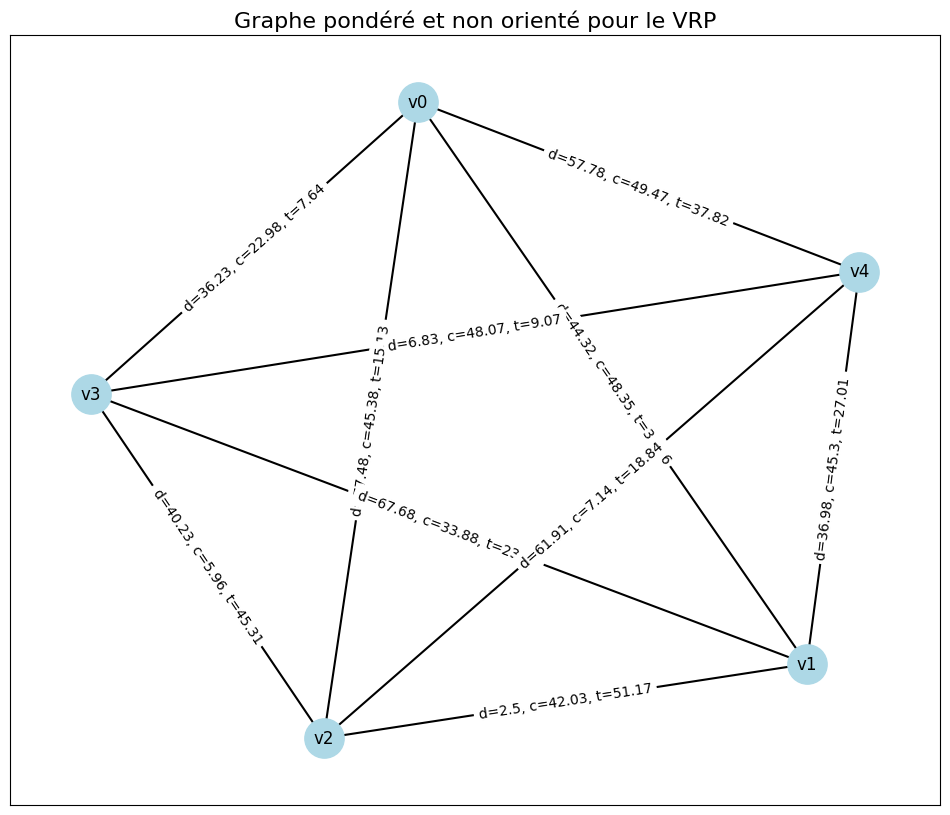

In [4]:
import matplotlib.pyplot as plt
import random
import networkx as nx

num_clients = 4 
depot = 0
nodes = [depot] + [i for i in range(1, num_clients + 1)]
G = nx.Graph()
for node in nodes:
    G.add_node(node)

for i in nodes:
    for j in nodes:
        if i < j:  
            distance = round(random.uniform(1, 100), 2)  
            cost = round(random.uniform(1, 50), 2)       
            time = round(random.uniform(1, 60), 2)     
            G.add_edge(i, j, distance=distance, cost=cost, time=time)

mapping = {node: f"v{node}" for node in G.nodes}
G = nx.relabel_nodes(G, mapping)
pos = nx.spring_layout(G, seed=42)  
plt.figure(figsize=(12, 10)) 
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
edge_labels = {
    (u, v): f"d={data['distance']}, c={data['cost']}, t={data['time']}"
    for u, v, data in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.title("Graphe pond√©r√© et non orient√© pour le VRP", fontsize=16)
plt.show()


### Transformation du VRP en TSP

Pour transformer le VRP en TSP, **on cr√©e ùëò copies du d√©p√¥t dans le graphe**. Ces copies repr√©sentent **les ùëò tourn√©es distinctes du VRP**. En attribuant des co√ªts tr√®s √©lev√©s entre ces copies, on emp√™che le TSP de relier plusieurs d√©p√¥ts dans une m√™me boucle. Chaque copie devient ainsi le d√©part et l‚Äôarriv√©e d‚Äôune tourn√©e sp√©cifique, simulant l‚Äôutilisation de ùëò v√©hicules dans le TSP.
Plusieurs contraintes sont respect√©s pour les poids des aretes
- Les distances entre les clients sont conserv√©es
- Les distances entre les copies du d√©p√¥t sont fix√©es √† **une grande valeur ùëÄ** pour d√©courager le passage direct entre ces copies
-Les distances entre chaque copie du d√©p√¥t $v_0^{(i)}$ et les clients sont √©gales √† celles du d√©p√¥t original $v_0$ dans l‚Äôinstance VRP.


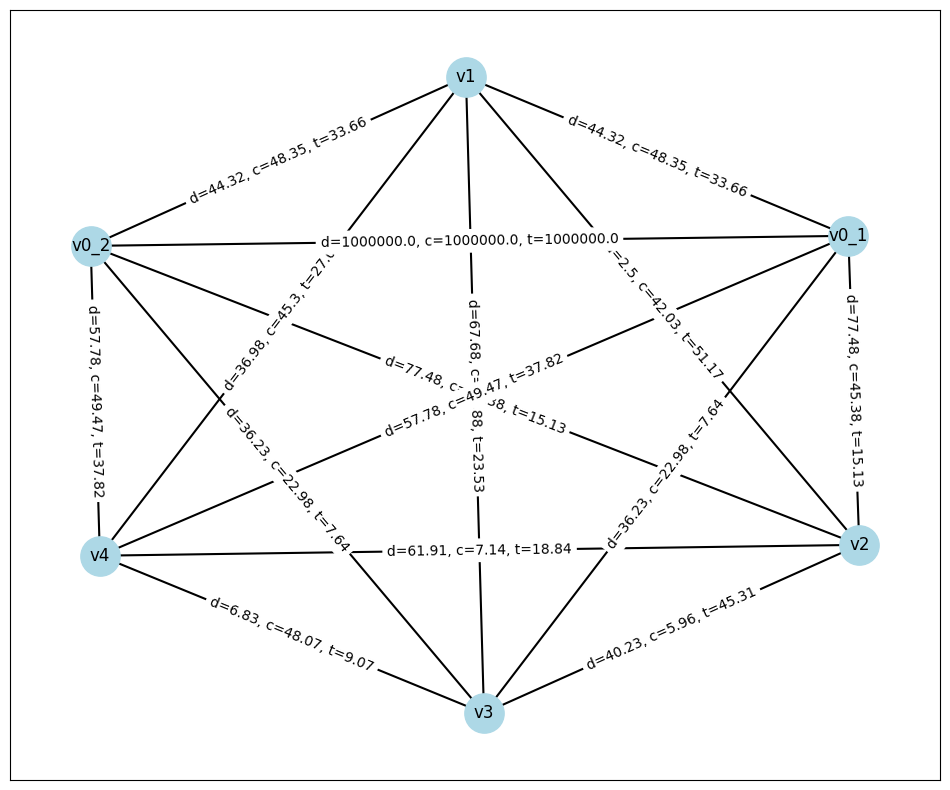

In [5]:
nombre_camion = 2
for i in range(1, nombre_camion + 1):
    depot_copy = f"v0_{i}"
    G.add_node(depot_copy)
    for node in G.nodes:
        if node != depot_copy and not node.startswith("v0_"):  
            original_edge = G.get_edge_data("v0", node)
            if original_edge:
                G.add_edge(depot_copy, node, **original_edge)

for i in range(1, nombre_camion + 1):
    for j in range(i + 1, nombre_camion + 1):
        G.add_edge(f"v0_{i}", f"v0_{j}", distance=1e6, cost=1e6, time=1e6)

if G.has_node("v0"):
    G.remove_node("v0")

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
edge_labels = {
    (u, v): f"d={data['distance']}, c={data['cost']}, t={data['time']}"
    for u, v, data in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.show()

###  Conclusion sur la complexit√© du VRP

Le **Vehicle Routing Problem (VRP)** est une **g√©n√©ralisation** du **probl√®me du voyageur de commerce (TSP)**.

Nous avons montr√© qu‚Äôune instance de VRP peut √™tre transform√©e en une instance **√©quivalente de TSP en temps polynomial**, notamment en **dupliquant le d√©p√¥t** et en **modifiant les co√ªts** du graphe.

Or, le **TSP est un probl√®me NP-complet**, ce qui signifie qu‚Äôil **n‚Äôexiste pas d‚Äôalgorithme polynomial connu** permettant de le r√©soudre efficacement dans tous les cas.

Cette r√©duction polynomiale montre donc que le VRP est lui aussi **NP-complet**, car **il est au moins aussi complexe que le TSP**.


### G√©n√©ration des instances al√©atoires

In [6]:
def generate_weight(restricted_edge, weight_range):
    if random.random() < restricted_edge: time = 999
    else: time = random.randint(*weight_range)
    if random.random() < restricted_edge: distance = 999
    else: distance = random.randint(*weight_range)
    if random.random() < restricted_edge: cost = 999
    else: cost = random.randint(*weight_range)
    return time, distance, cost

def generate_graph(n, weight_range=(1, 100), restricted_edge=0.1, seed=None):
    if seed is not None:
        random.seed(seed)
        
    G = nx.complete_graph(n)

    # Ajouter des poids al√©atoires aux ar√™tes
    for u, v in G.edges():
        time, distance, cost = generate_weight(restricted_edge, weight_range)
        G[u][v]['time'] = time
        G[u][v]['distance'] = distance
        G[u][v]['cost'] = cost
    
    return G

In [7]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    edge_labels = {}
    for u, v, data in G.edges(data=True):
        time = data.get('time')
        distance = data.get('distance')
        cost = data.get('cost')
        edge_labels[(u, v)] = f"T:{time}, D:{distance}, C:{cost}"
    
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=250, font_size=7)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    plt.show()

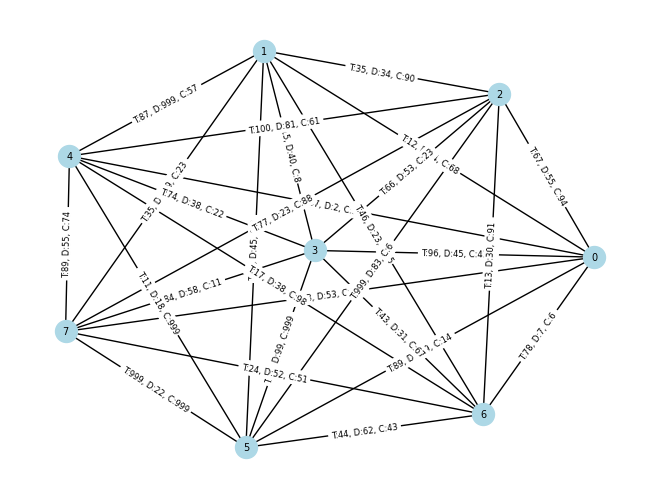

In [8]:
n = 8
G = generate_graph(n, weight_range=(1, 100), restricted_edge=0.1, seed=seed)
draw_graph(G)

# Mod√©lisation lin√©aire du probl√®me de tourn√©es de v√©hicules pour minimiser la distance (VRP)

Ce mod√®le lin√©aire permet de r√©soudre un probl√®me de tourn√©es de v√©hicules, o√π plusieurs camions partent d‚Äôun d√©p√¥t, visitent des clients, puis reviennent au d√©p√¥t.  
L‚Äôobjectif est de **minimiser la distance totale parcourue** tout en respectant certaines contraintes.
##  Donn√©es du probl√®me

Le syst√®me est mod√©lis√© par un **graphe orient√© pond√©r√©** $G = (V, E)$ :

- $V = \{v_0, v_1, ..., v_n\}$ : ensemble des sommets, repr√©sentant les clients √† visiter.  
- $v_0$ d√©signe le **d√©p√¥t** (point de d√©part et d‚Äôarriv√©e).
- $E \subseteq V \times V$ : ensemble des ar√™tes dirig√©es (routes).
- Chaque ar√™te $(i, j) \in E$ est associ√©e √† une **distance** $d_{ij} \in \mathbb{R}^+$.
- $k$ : nombre de v√©hicules disponibles.


##  Variables de d√©cision

- $x_{ij} \in \{0, 1\}$ : 1 si l‚Äôar√™te $(i, j)$ est emprunt√©e par un v√©hicule, 0 sinon.

- $u_i \in \mathbb{Z}$ : variable auxiliaire pour √©liminer les sous-tours (formulation MTZ), d√©finie pour tous les $i \in \{1, ..., n\}$.



##  Fonction objectif

Minimiser la **distance totale parcourue** :

$$
\min \sum_{(i,j) \in E} d_{ij} \cdot x_{ij}
$$


##  Contraintes

### 1. Visite unique de chaque client

Chaque client doit √™tre visit√© **exactement une fois** :

$$
\sum_{i \in V,\, i \ne j} x_{ij} = 1 \quad \forall j \in V 
$$

$$
\sum_{j \in V,\, j \ne i} x_{ij} = 1 \quad \forall i \in V 
$$


### 2. Utilisation du d√©p√¥t

Le d√©p√¥t $v_0$ est utilis√© par exactement $k$ v√©hicules :

$$
\sum_{j \in V } x_{0j} = k
$$

$$
\sum_{i \in V} x_{i0} = k
$$



### 3. √âlimination des sous-tours (MTZ)

Pour √©viter la cr√©ation de cycles ne passant pas par le d√©p√¥t :

$
1 \le u_i \le n \quad \forall i \in V 
$
$
u_i - u_j + n \cdot x_{ij} \le n - 1 \quad \forall i \ne j,\ i,j \in V
$

##  Interpr√©tation

Ce mod√®le permet de :

- Planifier les tourn√©es de $k$ v√©hicules partant et revenant au d√©p√¥t $v_0$
- Assurer la visite unique de chaque client
- √âviter les cycles internes sans passer par le d√©p√¥t
- **Minimiser la distance totale** pour un impact √©conomique et √©cologique r√©duit

In [9]:
def solve_vrp_with_pl(graph, depot, num_vehicles):
    prob = LpProblem("Vehicle_Routing_Problem", LpMinimize)
    # Variables de d√©cision
    x = LpVariable.dicts("x", [(i, j) for i in graph.nodes for j in graph.nodes if i != j], 0, 1, LpBinary)

    # Variables auxiliaires pour √©liminer les sous-tours
    u = LpVariable.dicts("u", [i for i in graph.nodes if i != depot], 1, len(graph.nodes) - 1, LpContinuous)

    #
    prob += lpSum(graph[i][j]['distance'] * x[i, j] for i, j in x)
    #contraintes
    for j in graph.nodes:
        if j != depot:
            prob += lpSum(x[i, j] for i in graph.nodes if i != j) == 1
            prob += lpSum(x[j, i] for i in graph.nodes if i != j) == 1
            
    prob += lpSum(x[depot, j] for j in graph.nodes if j != depot) == num_vehicles
    prob += lpSum(x[j, depot] for j in graph.nodes if j != depot) == num_vehicles

    for i in graph.nodes:
        for j in graph.nodes:
            if i != j and i != depot and j != depot:
                prob += u[i] - u[j] + len(graph.nodes) * x[i, j] <= len(graph.nodes) - 1

    
    prob.solve()

    # Extraction des r√©sultats
    if LpStatus[prob.status] == "Optimal":
        print("Solution optimale trouv√©e !")
        # Construire les cycles pour chaque v√©hicule
        routes = []
        used_edges = [(i, j) for i, j in x if x[i, j].varValue > 0.5]

        for _ in range(num_vehicles):
            cycle = []
            current_node = depot
            while True:
                for edge in used_edges:
                    if edge[0] == current_node:
                        cycle.append(edge)
                        used_edges.remove(edge)
                        current_node = edge[1]
                        break
                if current_node == depot:
                    break
            routes.append(cycle)

        # Formater les cycles pour chaque v√©hicule
        formatted_routes = []
        for route in routes:
            formatted_routes.append([edge[0] for edge in route] + [depot])

        return formatted_routes, value(prob.objective)
    else:
        print("Aucune solution optimale trouv√©e.")
        return None, None



Solution optimale trouv√©e !
Routes optimis√©es : [[0, 1, 0], [0, 4, 5, 7, 2, 3, 0], [0, 6, 0]]
Distance totale : 225.0


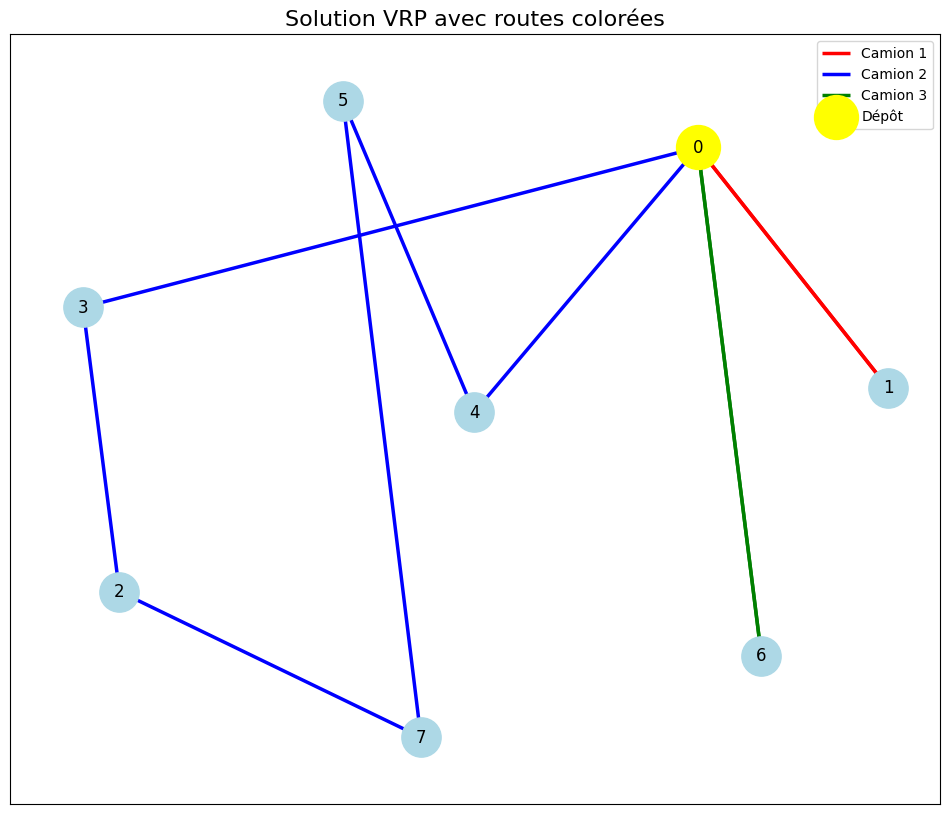

In [10]:
def plot_vrp_solution(graph, routes, depot):
    #dessiner le graphe
    pos = nx.spring_layout(graph, seed=42)  
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'] 
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(graph, pos, node_size=800, node_color='lightblue')
    nx.draw_networkx_labels(graph, pos, font_size=12, font_color='black')
    
    #dessiner les ar√™tes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]  
        edges = [(route[j], route[j + 1]) for j in range(len(route) - 1)]
        nx.draw_networkx_edges(graph, pos, edgelist=edges, width=2.5, edge_color=color, label=f'Camion {i + 1}')
    nx.draw_networkx_nodes(graph, pos, nodelist=[depot], node_size=1000, node_color='yellow', label='D√©p√¥t')
    plt.title("Solution VRP avec routes color√©es", fontsize=16)
    plt.legend()
    plt.show()
# R√©soudre le VRP gr√¢ce √† la programmation lin√©aire
routes, total_distance = solve_vrp_with_pl(G, depot=0, num_vehicles=3)
# Afficher les r√©sultats
if routes:
    print("Routes optimis√©es :", routes)
    print("Distance totale :", total_distance)
    plot_vrp_solution(G, routes, depot=0)

In [11]:
def robust_vrp_tabou(graph, depot, num_vehicles):
    nodes = list(graph.nodes())
    nodes.remove(depot)
    random.shuffle(nodes)
    split = [nodes[i::num_vehicles] for i in range(num_vehicles)]
    current = [[depot] + route + [depot] for route in split]
    best = copy.deepcopy(current)

    def cost(sol):
        # Calcul du co√ªt total des trajets pour tous les v√©hicules
        return sum(sum(graph[r[i]][r[i+1]]['weight'] for i in range(len(r)-1)) for r in sol)

    best_cost = cost(best)
    tabu, tenure = [], 10

    for _ in range(500):  # Nombre d'it√©rations
        neighborhood = []
        for _ in range(100):  # Nombre de voisins √† g√©n√©rer
            n = copy.deepcopy(current)
            a, b = random.sample(range(num_vehicles), 2)
            if len(n[a]) > 2 and len(n[b]) > 2:
                # √âchanger des clients entre les deux v√©hicules
                i, j = random.randint(1, len(n[a])-2), random.randint(1, len(n[b])-2)
                # √âchanger les clients dans les routes a et b
                move = (n[a][i], n[b][j])
                n[a][i], n[b][j] = n[b][j], n[a][i]
                neighborhood.append((n, move))

        best_n, best_n_cost = None, float('inf')
        for n, m in neighborhood:
            # Si le mouvement n'est pas dans la liste tabou, on l'√©value
            if m not in tabu:
                c = cost(n)
                if c < best_n_cost:
                    best_n, best_n_cost, best_move = n, c, m

        # Si on a trouv√© une meilleure solution, on met √† jour
        if best_n:
            current = best_n
            tabu.append(best_move)
            if len(tabu) > tenure:
                tabu.pop(0)
            if best_n_cost < best_cost:
                best, best_cost = copy.deepcopy(current), best_n_cost

    return best

In [12]:
depot = 0
num_vehicles = 2

solution = robust_vrp_tabou(G, depot, num_vehicles)

for idx, route in enumerate(solution):
    print(f"V√©hicule {idx+1} : {route}")

NameError: name 'copy' is not defined

In [ ]:
def robust_vrp(graph, depot):
    unvisited = set(graph.nodes())
    unvisited.remove(depot)
    routes = []

    while unvisited:
        current_route = [depot]
        visited_this_trip = set()


        reachable = [node for node in unvisited if nx.has_path(graph, depot, node)]
        if not reachable:
            start = unvisited.pop()
            current_route = [start]
            visited_this_trip.add(start)
        else:
            closest = min(reachable, key=lambda node: nx.shortest_path_length(graph, depot, node, weight='weight'))
            path = nx.shortest_path(graph, depot, closest, weight='weight')
            current_route += path[1:]
            visited_this_trip.update(path[1:])
            unvisited -= set(path[1:])

        current = current_route[-1]

        while True:
            next_nodes = [n for n in graph.neighbors(current) if n in unvisited]
            if not next_nodes:
                break
            next_node = min(next_nodes, key=lambda x: graph[current][x]['weight'])
            current_route.append(next_node)
            visited_this_trip.add(next_node)
            unvisited.remove(next_node)  
            current = next_node
        if current != depot and nx.has_path(graph, current, depot):
            back_path = nx.shortest_path(graph, current, depot, weight='weight')
            current_route += back_path[1:]

        routes.append(current_route)

    return routes

In [ ]:
routes = robust_vrp(G, depot)

print("\nüöö Tourn√©es optimis√©es :")
for i, route in enumerate(routes):
    print(f"Camion {i+1} : {' -> '.join(map(str, route))}")


üöö Tourn√©es optimis√©es :
Camion 1 : 0 -> 3 -> 8 -> 4 -> 7 -> 5 -> 2 -> 10 -> 9 -> 1 -> 6 -> 3 -> 0


### M√©ta heuristique
Nous avons fait le choix d'utiliser deux m√©ta heuristiques pour r√©soudre notre probl√®me de tourn√©es de v√©hicules. Ces deux algorithmes sont les suivants :
- **la colonie de fourmis** : qui s'inspire du comportement des fourmis pour trouver le chemin le plus court entre le d√©p√¥t et les clients.
- **la recherche tabou** : qui utilise une m√©moire pour √©viter de revisiter les solutions d√©j√† explor√©es, permettant ainsi d'explorer efficacement l'espace de recherche.

Routes optimis√©es : [[0, 4, 5, 7, 2, 0], [0, 6, 3, 1, 0]]
Distance totale : 222


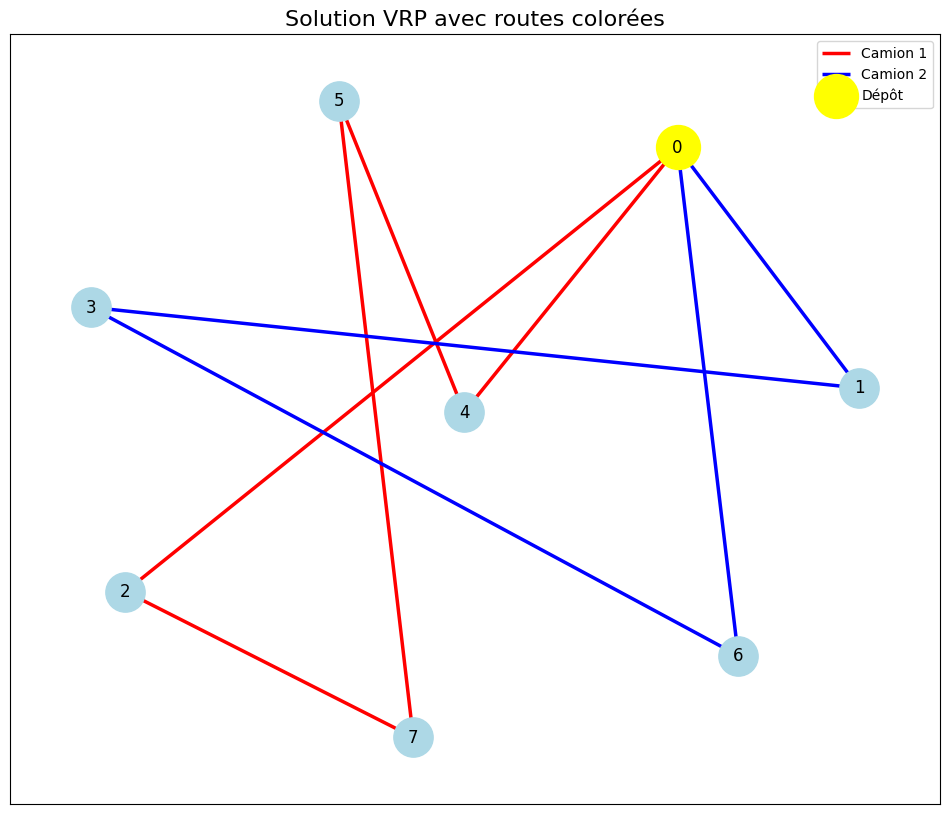

In [73]:
def ant_colony_vrp_fast(graph, depot, max_nodes=5, num_ants=10, num_iterations=50, alpha=1, beta=2, evaporation_rate=0.5, pheromone_init=1.0):

    pheromones = {edge: pheromone_init for edge in graph.edges}
    best_routes = None
    best_cost = float('inf')
    for iteration in range(num_iterations):
        for ant in range(num_ants):
            unvisited = set(graph.nodes)
            unvisited.remove(depot)
            routes = []
            total_cost = 0

            while unvisited:
                current_route = [depot]
                current_node = depot

                while unvisited and len(current_route) - 1 < max_nodes: 
                    neighbors = [n for n in graph.neighbors(current_node) if n in unvisited]
                    if not neighbors:
                        break

                    probabilities = []
                    for neighbor in neighbors:
                        edge = (current_node, neighbor) if (current_node, neighbor) in pheromones else (neighbor, current_node)
                        pheromone = pheromones[edge]
                        distance = graph[current_node][neighbor]['distance']
                        probabilities.append((neighbor, (pheromone ** alpha) * ((1 / distance) ** beta)))

                    if not probabilities:
                        break

                    total_prob = sum(prob[1] for prob in probabilities)
                    next_node = random.choices(
                        [node for node, _ in probabilities],
                        [prob / total_prob for _, prob in probabilities]
                    )[0]

                    current_route.append(next_node)
                    total_cost += graph[current_node][next_node]['distance']
                    unvisited.remove(next_node)
                    current_node = next_node

                if current_node != depot:
                    current_route.append(depot)
                    total_cost += graph[current_node][depot]['distance']

                routes.append(current_route)

            if total_cost < best_cost:
                best_cost = total_cost
                best_routes = routes

        for edge in pheromones:
            pheromones[edge] *= (1 - evaporation_rate)

        for route in best_routes:
            for i in range(len(route) - 1):
                edge = (route[i], route[i + 1]) if (route[i], route[i + 1]) in pheromones else (route[i + 1], route[i])
                pheromones[edge] += 1 / best_cost

    return best_routes, best_cost

best_routes, best_cost = ant_colony_vrp_fast(G, depot=0, max_nodes=4, num_ants=10, num_iterations=100)
if best_routes:
    print("Routes optimis√©es :", best_routes)
    print("Distance totale :", best_cost)
    plot_vrp_solution(G, best_routes, depot=0)


Routes optimis√©es : [[0, 4, 5, 7, 2, 0], [0, 1, 3, 6, 0]]
Distance totale : 222


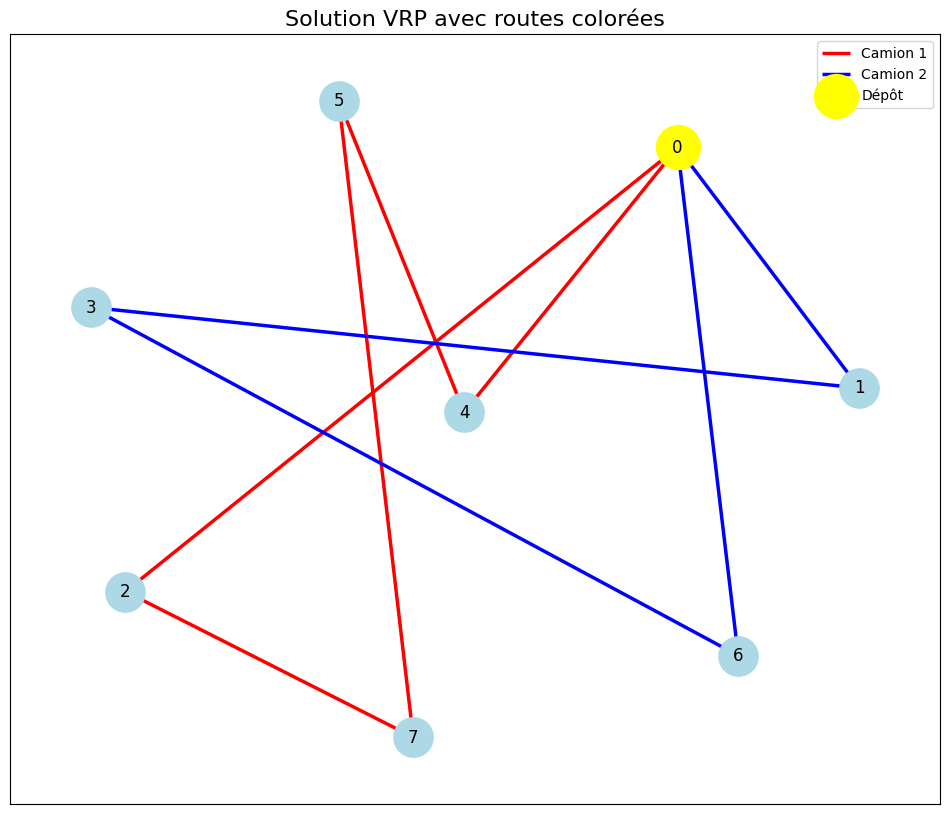

In [ ]:
def tabu_vrp_with_node_limit(graph, depot, max_nodes, max_iter=100, tabu_tenure=10):
    nodes = list(graph.nodes())
    nodes.remove(depot)
    random.shuffle(nodes)


    num_vehicles = (len(nodes) + max_nodes - 2) // (max_nodes - 1)
    current_solution = [[depot] + nodes[i::num_vehicles] + [depot] for i in range(num_vehicles)]
    best_solution = current_solution[:]

    def calculate_cost(solution):
        total_cost = 0
        for route in solution:
            if len(route) - 2 > max_nodes:  
                return float('inf') 
            for i in range(len(route) - 1):
                total_cost += graph[route[i]][route[i + 1]]['distance']
        return total_cost

    best_cost = calculate_cost(best_solution)
    tabu_list = []

    for _ in range(max_iter):
        neighbors = []
        for i in range(len(current_solution)):
            for j in range(len(current_solution)):
                if i != j:
                    for k in range(1, len(current_solution[i]) - 1):
                        for l in range(1, len(current_solution[j]) - 1):
                            new_solution = [route[:] for route in current_solution]
                            new_solution[i][k], new_solution[j][l] = new_solution[j][l], new_solution[i][k]
                            if all(len(route) - 2 <= max_nodes for route in new_solution): 
                                neighbors.append((new_solution, (i, j, k, l)))

        # Trier les voisins par co√ªt
        neighbors = [(sol, move, calculate_cost(sol)) for sol, move in neighbors if move not in tabu_list]
        neighbors.sort(key=lambda x: x[2])

        # S√©lectionner le meilleur voisin
        if neighbors:
            best_neighbor, best_move, best_neighbor_cost = neighbors[0]
            current_solution = best_neighbor
            tabu_list.append(best_move)
            if len(tabu_list) > tabu_tenure:
                tabu_list.pop(0)

            # Mettre √† jour la meilleure solution
            if best_neighbor_cost < best_cost:
                best_solution = best_neighbor
                best_cost = best_neighbor_cost

    return best_solution, best_cost


best_routes, best_distance = tabu_vrp_with_node_limit(G, depot=0, max_nodes=5, max_iter=100, tabu_tenure=10)
print("Routes optimis√©es :", best_routes)
print("Distance totale :", best_distance)
plot_vrp_solution(G, best_routes, depot=0)

## Comparaison des r√©sultats:

### R√©f√©rences utiles

- https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce
- https://fr.wikipedia.org/wiki/Probl%C3%A8me_de_tourn%C3%A9es_de_v%C3%A9hicules
- Workshop
- https://networkx.org/documentation/stable/reference/introduction.html
- https://www.guru99.com/fr/travelling-salesman-problem.html#:~:text=Le%20probl%C3%A8me%20du%20voyageur%20de%20commerce%20%28TSP%29%20est,fa%C3%A7on%20exponentielle%20avec%20l%E2%80%99augmentation%20du%20nombre%20de%20villes.
- https://github.com/jwang0306/vehicle-routing-problem?tab=readme-ov-file
- https://www.youtube.com/watch?v=GiDsjIBOVoA&list=TLPQMjcwNDIwMjWGmE-QXy8F6w&index=1&pp=gAQBiAQB